In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


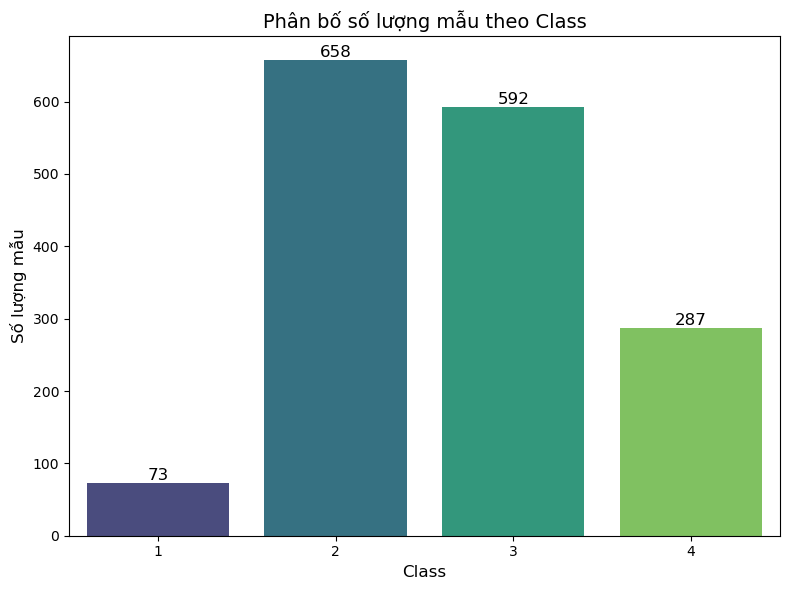

In [59]:
df = pd.read_excel('DS_Obesity.xlsx')
# Đếm số lượng mẫu theo từng class
class_counts = df['Class'].value_counts()
all_columns = df.drop(columns=['Class']).columns.tolist()
# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
bars = sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")

# Ghi giá trị trên mỗi cột
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}',
                  (bar.get_x() + bar.get_width() / 2, height),
                  ha='center', va='bottom', fontsize=12)

plt.title("Phân bố số lượng mẫu theo Class", fontsize=14)
plt.xlabel("Class", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.xticks(ticks=range(len(class_counts.index)), labels=sorted(class_counts.index))
# plt.xticks(ticks=range(len(class_counts.index)), labels=class_counts.index)
plt.tight_layout()
plt.show()

In [60]:
import json
with open('mapping.json', encoding='utf-8') as f:
    mapping = json.load(f)
# ánh xạ các giá trị trong các cột thành các giá trị số nguyên tương ứng    

Các lớp hiện có trong y: Counter({2: 658, 3: 592, 4: 287, 1: 73})
Phân bố sau SMOTE: Counter({2: 658, 3: 592, 4: 401, 1: 356})


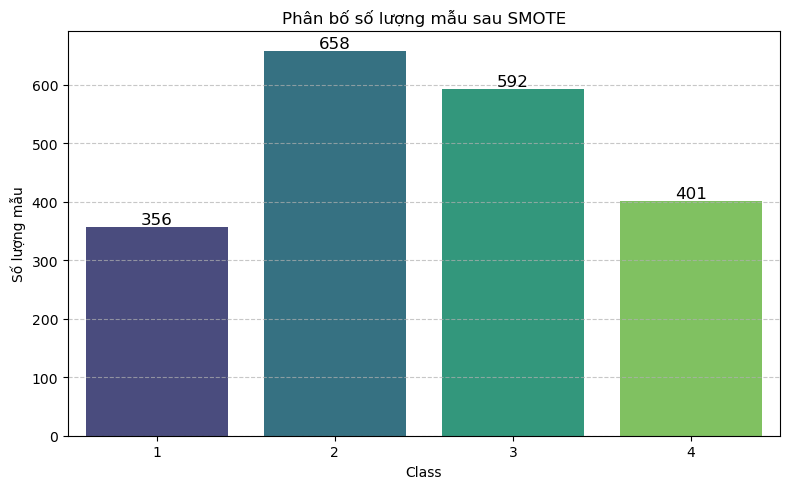

In [61]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Define X as the feature set and y as the target column
X = df.drop(columns=['Class'])
y = df['Class']

# Xác định các lớp thực tế trong y
print("Các lớp hiện có trong y:", Counter(y))

# Cập nhật sampling_strategy để phù hợp với các lớp thực tế
smote = SMOTE(sampling_strategy={
    1: 356,  # Thiếu cân
    4: 401   # Béo phì
}, random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

print("Phân bố sau SMOTE:", Counter(y_resampled))

import matplotlib.pyplot as plt

# Đếm số lượng mỗi lớp
class_counts = Counter(y_resampled)

# Tạo biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
bars = sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")

# Ghi giá trị trên mỗi cột
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{int(height)}',
                  (bar.get_x() + bar.get_width() / 2, height),
                  ha='center', va='bottom', fontsize=12)

plt.xlabel('Class')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bố số lượng mẫu sau SMOTE')
plt.xticks(ticks=range(len(class_counts.keys())), labels=sorted(class_counts.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [62]:
from sklearn.model_selection import train_test_split

#tách đặc trưng
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled,
    test_size=0.3,
    random_state=42,
    stratify=y_resampled
)
# đảm bảo phân bố các lớp trong tập huấn luyện và tập kiểm tra là giống nhau

In [63]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
print("Dummy Classifier Report:")
print(classification_report(y_test, y_pred_dummy, zero_division=0))



Dummy Classifier Report:
              precision    recall  f1-score   support

           1       0.18      0.16      0.17       107
           2       0.33      0.31      0.32       198
           3       0.27      0.26      0.27       178
           4       0.20      0.25      0.22       120

    accuracy                           0.26       603
   macro avg       0.25      0.25      0.25       603
weighted avg       0.26      0.26      0.26       603



#rất kém

In [64]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf'],
    'probability': [True]
}

grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
# In ra báo cáo
y_pred_svc = grid.best_estimator_.predict(X_test)
print("SVC Report (Best Estimator):")
print(classification_report(y_test, y_pred_svc, zero_division=0))
#chạy mô hình với các tham số tốt nhất


Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf', 'probability': True}
SVC Report (Best Estimator):
              precision    recall  f1-score   support

           1       0.96      0.99      0.98       107
           2       0.84      0.88      0.86       198
           3       0.81      0.78      0.80       178
           4       0.89      0.85      0.87       120

    accuracy                           0.86       603
   macro avg       0.88      0.88      0.88       603
weighted avg       0.86      0.86      0.86       603



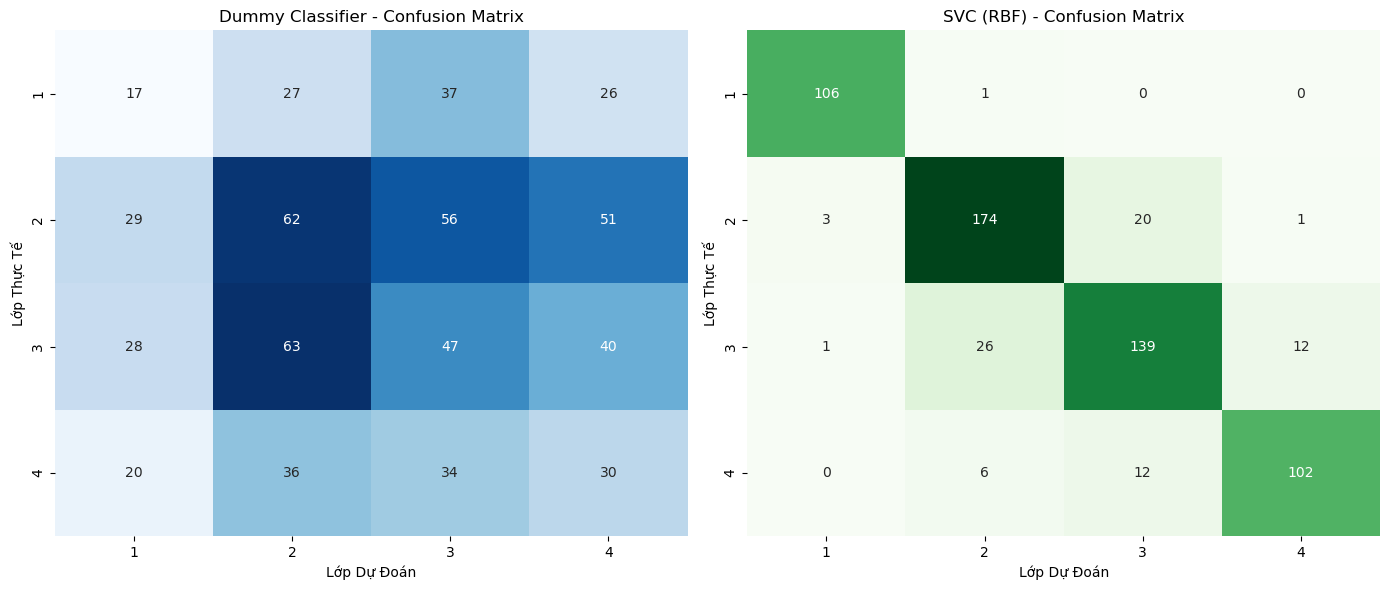

In [65]:

from sklearn.metrics import confusion_matrix

dummy_conf = confusion_matrix(y_test, y_pred_dummy)
svc_conf = confusion_matrix(y_test, y_pred_svc)
labels = ['1', '2', '3', '4']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(dummy_conf, annot=True, fmt="d", cmap="Blues", ax=ax1, cbar=False,
            xticklabels=labels, yticklabels=labels)
ax1.set_title("Dummy Classifier - Confusion Matrix")
ax1.set_xlabel("Lớp Dự Đoán")
ax1.set_ylabel("Lớp Thực Tế")

sns.heatmap(svc_conf, annot=True, fmt="d", cmap="Greens", ax=ax2, cbar=False,
            xticklabels=labels, yticklabels=labels)
ax2.set_title("SVC (RBF) - Confusion Matrix")
ax2.set_xlabel("Lớp Dự Đoán")
ax2.set_ylabel("Lớp Thực Tế")

plt.tight_layout()
plt.show()


So với Dummy Classifier, mô hình SVC thể hiện hiệu suất vượt trội rõ rệt trên mọi chỉ số đánh giá. Dummy chỉ đạt độ chính xác tổng thể là 30%, trong khi SVC đạt tới 86%, cho thấy khả năng học và phân loại thực sự từ dữ liệu.

Xét riêng từng lớp, Dummy có precision dao động từ 0.22 đến 0.35, rất thấp và gần như đoán ngẫu nhiên. Ngược lại, SVC đạt precision từ 0.81 đến 0.96, nổi bật ở lớp thiếu cân (0.96) và béo phì (0.89).

Về recall, Dummy dao động quanh 0.21 – 0.34, còn SVC có recall rất cao ở mọi lớp, đặc biệt lớp thiếu cân lên tới 0.99, cho thấy mô hình rất ít bỏ sót mẫu ở lớp này.

F1-score của Dummy chỉ quanh 0.21 – 0.34, trong khi SVC đạt từ 0.80 – 0.98, minh chứng rằng mô hình cân bằng tốt giữa precision và recall.

Ma trận nhầm lẫn cũng khẳng định SVC nhận diện chính xác đa số các mẫu. Ví dụ, lớp 1 (thiếu cân) được dự đoán đúng 106/107 mẫu, lớp 4 (béo phì) đúng 102/120 mẫu.

Trong khi đó, Dummy phân loại rối rắm, nhầm lẫn nặng giữa tất cả các lớp, như lớp 3 bị đoán nhầm thành lớp 2 tới 60 lần, thể hiện rõ tính ngẫu nhiên.

Đặc biệt, macro avg và weighted avg của SVC đều ở mức 0.88 và 0.86, trong khi Dummy chỉ đạt khoảng 0.29 – 0.30, cho thấy sự khác biệt đột phá giữa hai mô hình.

Từ các phân tích trên, có thể khẳng định SVC là lựa chọn phù hợp và hiệu quả để triển khai vào hệ thống trang web phân loại béo phì. Mô hình không chỉ chính xác mà còn ổn định across all classes.

Việc sử dụng SVC với tham số tối ưu (C=10, gamma=0.1, kernel='rbf') đảm bảo hiệu suất cao và đáng tin cậy trong môi trường thực tế.



In [67]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa dữ liệu đầu vào vì chi2 yêu cầu dữ liệu không âm
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_train)

# Tính chi2 và p-values
chi2_stats, p_values = chi2(X_scaled, y_train)

# In p-value dạng thập phân
print("P-value cho từng đặc trưng:")
for feature, p in zip(X_train.columns, p_values):
    print(f"{feature}: ~ {p:.20f}")


P-value cho từng đặc trưng:
Sex: ~ 0.00000000000194261917
Age: ~ 0.00000000000000000000
Height: ~ 0.07700146600169137379
Overweight_Obese_Family: ~ 0.00001026670298909887
Consumption_of_Fast_Food: ~ 0.00000000000000007137
Frequency_of_Consuming_Vegetables: ~ 0.00000000000000000000
Number_of_Main_Meals_Daily: ~ 0.00000000000000000000
Food_Intake_Between_Meals: ~ 0.14406558050872905752
Smoking: ~ 0.00000000000000000000
Liquid_Intake_Daily: ~ 0.00000000000001233143
Calculation_of_Calorie_Intake: ~ 0.00000003670373422552
Physical_Excercise: ~ 0.00000000000000000000
Schedule_Dedicated_to_Technology: ~ 0.14570887118377723324
Type_of_Transportation_Used: ~ 0.00000000000000006773


p-value: Đo mức độ liên quan giữa feature và target.

p < 0.05 → đặc trưng có ý nghĩa thống kê.

p càng nhỏ → đặc trưng càng quan trọng.

chỉ có chiều cao có  thể xem là không có ý nghĩa thống kê

Vẽ biểu đồ tương quan giữa một số đặc trưng và Class, dùng các đặc trưng có 
p < 0.05

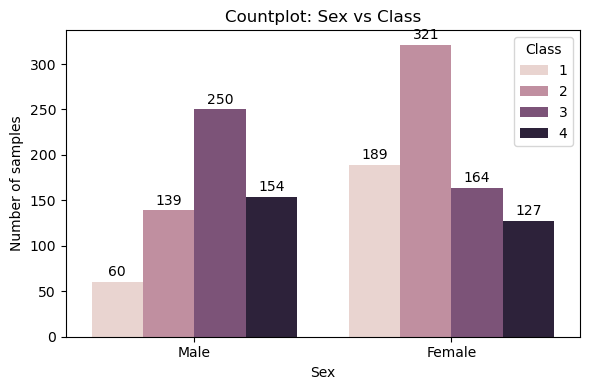

In [68]:
plt.figure(figsize=(6, 4))

# Chuẩn bị dữ liệu
df_plot = X_train[['Sex']].copy()
df_plot['Class'] = y_train

# Map 1 ➔ Male, 2 ➔ Female
df_plot['Sex'] = df_plot['Sex'].map({1: 'Male', 2: 'Female'})

# Vẽ countplot
ax=sns.countplot(data=df_plot, x='Sex', hue='Class')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)
# Sửa tiêu đề, trục y
plt.title("Countplot: Sex vs Class")
plt.ylabel("Number of samples")

plt.tight_layout()
plt.show()


Nam giới có tỷ lệ thừa cân/béo phì khoảng 67%,

Nữ giới có tỷ lệ thừa cân/béo phì khoảng 36%.

➔ Nam cao hơn Nữ khoảng 31%.

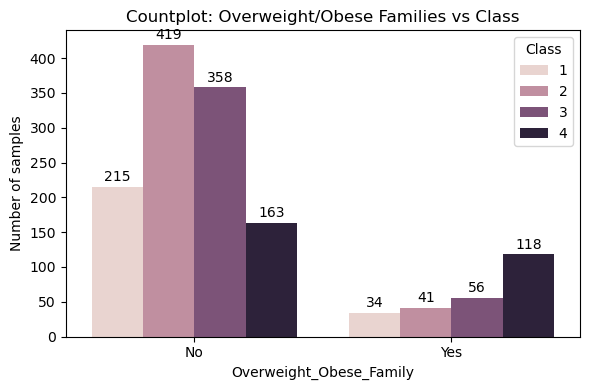

In [69]:
plt.figure(figsize=(6, 4))

# Chuẩn bị dữ liệu
df_plot = X_train[['Overweight_Obese_Family']].copy()
df_plot['Class'] = y_train

# Map 1 ➔ Yes, 2 ➔ No
df_plot['Overweight_Obese_Family'] = df_plot['Overweight_Obese_Family'].map({1: 'Yes', 2: 'No'})

# Vẽ countplot
ax = sns.countplot(data=df_plot, x='Overweight_Obese_Family', hue='Class')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)
# Sửa tiêu đề, trục y
plt.title("Countplot: Overweight/Obese Families vs Class")
plt.ylabel("Number of samples")

plt.tight_layout()
plt.show()


Gia đình không có người béo phì ➔ Tỷ lệ con cái thừa cân/béo phì khoảng 45%.

Gia đình có người béo phì ➔ Tỷ lệ con cái thừa cân/béo phì khoảng 70%.

➔ Gia đình có người béo phì cao hơn 25% so với gia đình bình thường.



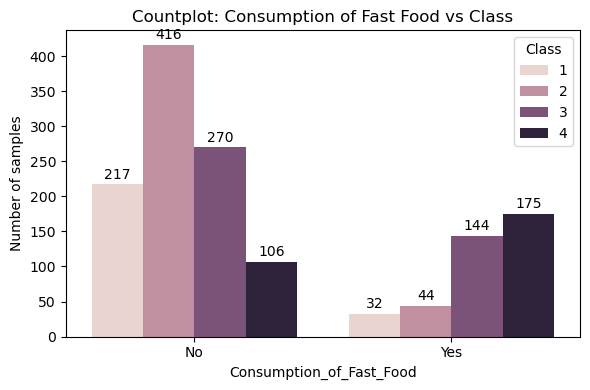

In [70]:
plt.figure(figsize=(6, 4))

# Chuẩn bị dữ liệu
df_plot = X_train[['Consumption_of_Fast_Food']].copy()
df_plot['Class'] = y_train

# Map 1 ➔ Male, 2 ➔ Female
df_plot['Consumption_of_Fast_Food'] = df_plot['Consumption_of_Fast_Food'].map({1: 'Yes', 2: 'No'})

# Vẽ countplot
ax = sns.countplot(data=df_plot, x='Consumption_of_Fast_Food', hue='Class')


# Thêm giá trị trên mỗi cột
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)
# Sửa tiêu đề, trục y
plt.title("Countplot: Consumption of Fast Food vs Class")
plt.ylabel("Number of samples")

plt.tight_layout()
plt.show()

Nhóm không ăn fast food ➔ Tỷ lệ thừa cân/béo phì khoảng 37%.

Nhóm có ăn fast food ➔ Tỷ lệ thừa cân/béo phì khoảng 81%.

➔ Ăn fast food làm tăng tỷ lệ béo phì lên cao hơn ~44% so với người không ăn.

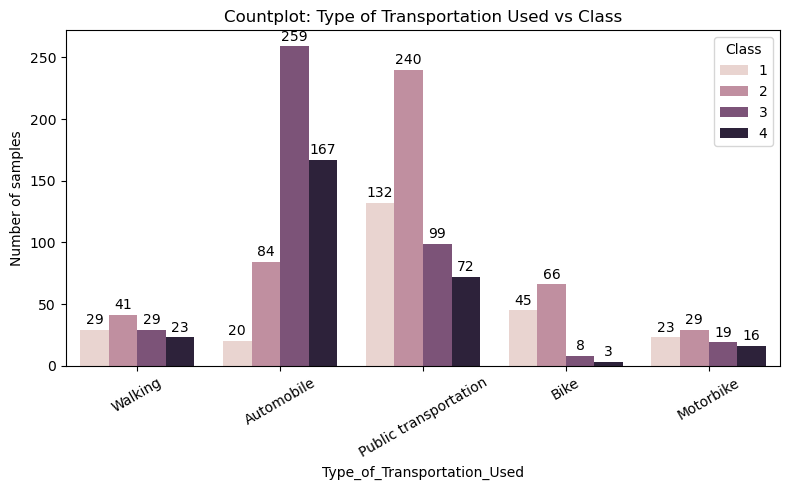

In [71]:
plt.figure(figsize=(8, 5))

# Chuẩn bị dữ liệu
df_plot = X_train[['Type_of_Transportation_Used']].copy()
df_plot['Class'] = y_train

# Map các giá trị
df_plot['Type_of_Transportation_Used'] = df_plot['Type_of_Transportation_Used'].map({
    1: "Automobile",
    2: "Motorbike",
    3: "Bike",
    4: "Public transportation",
    5: "Walking"
})

# Vẽ countplot
ax=sns.countplot(data=df_plot, x='Type_of_Transportation_Used', hue='Class')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)
# Sửa tiêu đề, trục y
plt.title("Countplot: Type of Transportation Used vs Class")
plt.ylabel("Number of samples")
plt.xticks(rotation=30)  # Xoay nhãn x-axis cho khỏi đụng nhau

plt.tight_layout()
plt.show()


Nhóm người sử dụng ô tô có tỷ lệ thừa cân và béo phì cao nhất, cho thấy có thể có mối liên hệ giữa việc ít vận động (do sử dụng phương tiện cá nhân) và nguy cơ thừa cân, béo phì.

Ngược lại, nhóm người sử dụng xe đạp có tỷ lệ thừa cân và béo phì thấp nhất, điều này phù hợp với lợi ích của việc đạp xe như một hình thức vận động thể chất.

Nhóm sử dụng phương tiện công cộng cũng có tỷ lệ thừa cân béo phì thấp hơn so với nhóm đi ô tô, có thể do việc đi bộ đến và đi từ trạm xe buýt/tàu điện ngầm cũng đóng góp vào hoạt động thể chất hàng ngày.

Việc đi bộ và đi xe máy có tỷ lệ thừa cân béo phì ở mức trung bình, cho thấy mức độ tác động đến cân nặng có thể khác nhau tùy thuộc vào tần suất và quãng đường di chuyển.

Biểu đồ này cho thấy một mối tương quan rõ rệt giữa loại phương tiện di chuyển được sử dụng

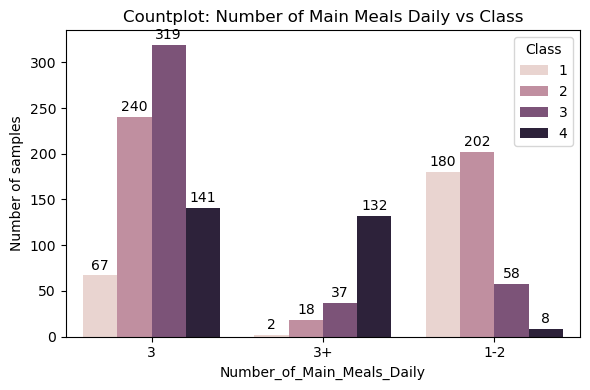

In [72]:
plt.figure(figsize=(6, 4))

# Chuẩn bị dữ liệu
df_plot = X_train[['Number_of_Main_Meals_Daily']].copy()
df_plot['Class'] = y_train

# Map 1 ➔ Male, 2 ➔ Female
df_plot['Number_of_Main_Meals_Daily'] = df_plot['Number_of_Main_Meals_Daily'].map(
    {1: '1-2', 2: '3', 3: '3+'}
)

# Vẽ countplot
ax=sns.countplot(data=df_plot, x='Number_of_Main_Meals_Daily', hue='Class')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=2)
# Sửa tiêu đề, trục y
plt.title("Countplot: Number of Main Meals Daily vs Class")
plt.ylabel("Number of samples")

plt.tight_layout()
plt.show()

Tỷ lệ thừa cân và béo phì cao nhất đáng kể ở nhóm ăn 3+ bữa chính mỗi ngày (khoảng 89.42%).

Tỷ lệ này thấp hơn ở nhóm ăn 3 bữa chính mỗi ngày (khoảng 59.97%).
Nhóm ăn 1-2 bữa chính mỗi ngày có tỷ lệ thừa cân và béo phì thấp nhất (khoảng 14.73%).

Số lượng bữa ăn chính hàng ngày có vẻ có mối liên hệ đáng kể với tình trạng cân nặng.
Ăn nhiều hơn 3 bữa chính mỗi ngày có liên quan đến tỷ lệ thừa cân và béo phì cao nhất. Điều này có thể là do tổng lượng calo nạp vào trong ngày cao hơn khi ăn nhiều bữa.
Ăn 3 bữa chính mỗi ngày cũng đi kèm với tỷ lệ thừa cân béo phì khá cao.

In [73]:

fields = [
    "Sex", "Age", "Height", "Overweight/Obese Families", "Consumption of Fast Food",
    "Frequency of Consuming Vegetables", "Number of Main Meals Daily", "Food Intake Between Meals",
    "Smoking", "Liquid Intake Daily", "Calculation of Calorie Intake", "Physical Excercise",
    "Schedule Dedicated to Technology", "Type of Transportation Used"
]
default_values = {
    "Sex": "Male",
    "Age": "36",
    "Height": "171",
    "Overweight/Obese Families": "No",
    "Consumption of Fast Food": "No",
    "Frequency of Consuming Vegetables": "Sometimes",
    "Number of Main Meals Daily": "3",
    "Food Intake Between Meals": "Sometimes",
    "Smoking": "No",
    "Liquid Intake Daily": "within the range of 1 to 2 liters",
    "Calculation of Calorie Intake": "No",
    "Physical Excercise": "in the range of 3-4 days",
    "Schedule Dedicated to Technology": "between 3 and 5 hours",
    "Type of Transportation Used": "Bike"
}


# Hàm đảo ngược mapping cho từng trường
def reverse_mapping(field):
    if field in mapping:
        return {str(v).lower(): int(k) for k, v in mapping[field].items()}
    return None

input_data = {}
for field in fields:
    rev_map = reverse_mapping(field)
    if rev_map:
        print(f"Chọn giá trị cho '{field}': {list(rev_map.keys())}")
        val = input(f"Nhập {field}: ").strip().lower()
        # Nếu nhập rỗng và có giá trị mặc định thì dùng mặc định
        if val == "" and field in default_values:
            val = str(default_values[field]).strip().lower()
            print(f"--> Tự động chọn giá trị mặc định: {val}")
        while val not in rev_map:
            print("Giá trị không hợp lệ. Vui lòng nhập lại hoặc để trống để dùng mặc định.")
            val = input(f"Nhập {field}: ").strip().lower()
            if val == "" and field in default_values:
                val = str(default_values[field]).strip().lower()
                print(f"--> Tự động chọn giá trị mặc định: {val}")
        input_data[field] = [rev_map[val]]
    else:
        print(f"Không tìm thấy mapping cho trường {field}, bỏ qua.")

        
for col in all_columns:
    if col not in input_data:
        if col in default_values:
            rev_map = reverse_mapping(col)
            val = str(default_values[col]).strip().lower()
            if rev_map and val in rev_map:
                input_data[col] = [rev_map[val]]
            else:
                input_data[col] = [default_values[col]]
        else:
            input_data[col] = [0]
input_df = pd.DataFrame(input_data)[all_columns]

# Dự đoán với DummyClassifier
pred = dummy.predict(input_df)[0]
class_mapping = mapping["Class"]
print(f"Kết quả dự đoán (Dummy): {pred} - {class_mapping[str(pred)]}")
# Ensure svc is defined as the best estimator from GridSearchCV
svc = grid.best_estimator_

pred_svc = svc.predict(input_df)[0]
print(f"Kết quả dự đoán (SVC): {pred_svc} - {class_mapping[str(pred_svc)]}")

Chọn giá trị cho 'Sex': ['male', 'female']
--> Tự động chọn giá trị mặc định: male
Chọn giá trị cho 'Age': ['18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54']
--> Tự động chọn giá trị mặc định: 36
Chọn giá trị cho 'Height': ['150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192']
--> Tự động chọn giá trị mặc định: 171
Chọn giá trị cho 'Overweight/Obese Families': ['yes', 'no']
--> Tự động chọn giá trị mặc định: no
Chọn giá trị cho 'Consumption of Fast Food': ['yes', 'no']
--> Tự động chọn giá trị mặc định: no
Chọn giá trị cho 'Frequency of Consuming Vegetables': ['rarely', 'som

In [74]:
from sklearn.preprocessing import StandardScaler
import joblib

# Define and fit the scaler
scaler = StandardScaler()
scaler.fit(X_train)

# Save the SVC model and scaler
joblib.dump(svc, 'svc_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']